In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# load the data

# load data
x_new = np.load('../../calesti-data/sequential/x_rf_60.npy') #next x_true_hr_t_sequential.npy
y_new = np.load('../../calesti-data/sequential/y_rf_60.npy')

x_new = torch.tensor(x_new.reshape(-1, x_new.shape[2])).to(torch.double)
y_new = torch.tensor(y_new).to(torch.double)

n1 = int(0.8*x_new.shape[0])
n2 = int(0.9*x_new.shape[0])
Xtr,  Ytr  = x_new[:n1], y_new[:n1]     # 80%
Xdev, Ydev = x_new[n1:n2], y_new[n1:n2]   # 10%
Xte,  Yte  = x_new[n2:], y_new[n2:]     # 10%

In [47]:
Xtr.shape, Ytr.shape

(torch.Size([5730, 60]), torch.Size([5730]))

In [49]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 100
g = torch.Generator().manual_seed(2147483647) # for reproducibility

#C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((x_new.shape[1], n_hidden), generator=g) * (5/3)/((x_new.shape[1])**0.5) #* 0.2
W2 = torch.rand((n_hidden, n_hidden_2), generator=g)* (5/3) *0.01
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
b2 = torch.randn(n_hidden_2,                        generator=g) * 0.01
W3 = torch.randn((n_hidden_2, 1),          generator=g) * 0.01
b3 = torch.randn(1,                      generator=g) * 0


W1 = W1.to(torch.double)
W2 = W2.to(torch.double)
W3 = W3.to(torch.double)



# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [W1, W2, W3, b2, b3, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

32601


In [50]:
torch.manual_seed(42); # seed rng for reproducibility

In [51]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
   

    # forward pass
    #emb = C[Xb] # embed the characters into vectors
    #embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = Xb @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    
    hpreact2 = h @ W2 + b2
    h2 = torch.tanh(hpreact2)
    
    logits = h2 @ W3 + b3 # output layer
    loss = F.l1_loss(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break


      0/ 200000: 8.1758


/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_62612/1256894152.py:35: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(logits, Yb) # loss function


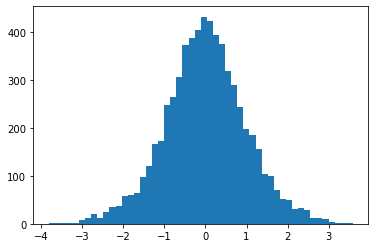

In [63]:
# visualise the output of first linear layer (i.e. preactivations) before sending it through tanh
plt.hist(hpreact.view(-1).tolist(),50);

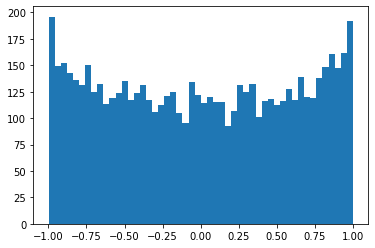

In [64]:
# vislaulising the first output of tanh
plt.hist(h.view(-1).tolist(), 50);

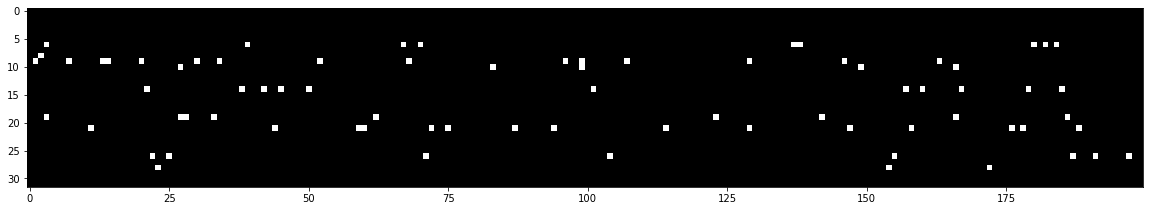

In [65]:
# visualise how many points of tanh outout are on the flat tails of it
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

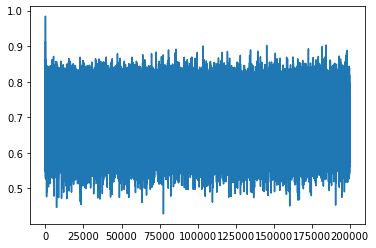

In [26]:
plt.plot(lossi)

In [27]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  
  hpreact = Xtr @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    hpreact = x @ W1 # + b1 # bias removed because of batch normalisation
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)

    hpreact2 = h @ W2 + b2
    h2 = torch.tanh(hpreact2)
    
    logits = h2 @ W3 + b3 # output layer
    loss = F.l1_loss(logits, Yb) # loss function

    print(split, loss.item())

split_loss('train')
split_loss('val')

train 6.098604687884317
val 6.127582260329992


/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_62612/3219333554.py:17: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([5730, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(logits, Yb) # loss function
/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_62612/3219333554.py:17: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([716, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(logits, Yb) # loss function


In [102]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = (torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5).to(torch.double)
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

input_size = Xtr.shape[1] # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility


layers = [
  Linear(input_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, 1, bias=False), BatchNorm1d(1),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.001
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #5/3

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



47102


In [103]:
input_size

60

In [3]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.l1_loss(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.001 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization



NameError: name 'g' is not defined

layer 2 (      Tanh): mean -0.01, std 0.61, saturated: 4.00%
layer 5 (      Tanh): mean +0.01, std 0.63, saturated: 2.72%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

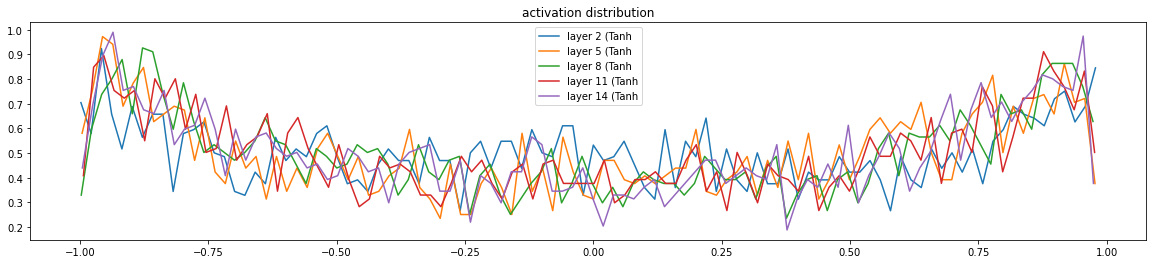

In [105]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

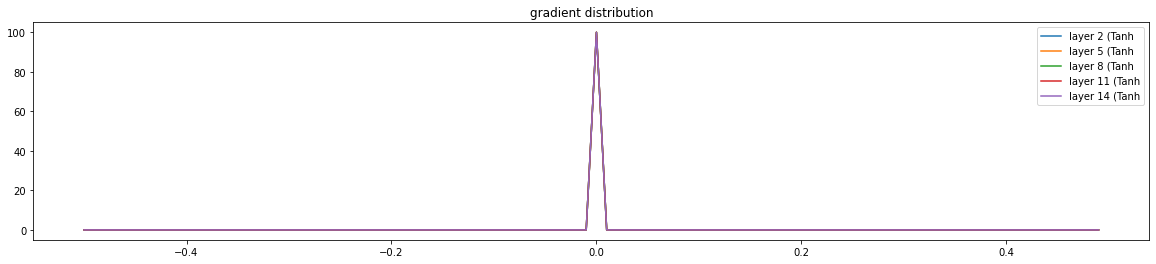

In [106]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight  (60, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight   (100, 1) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00


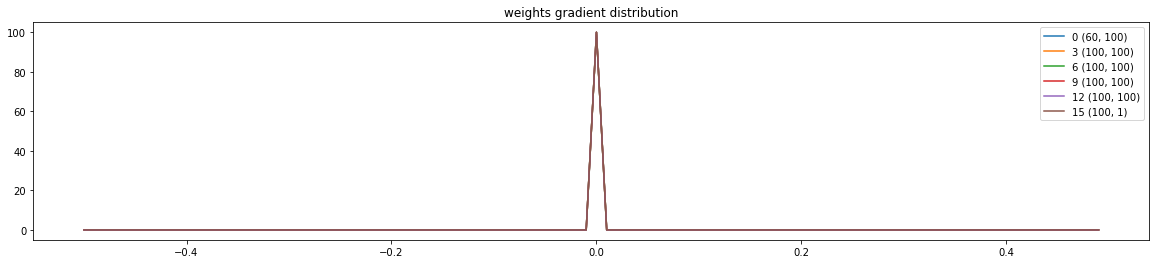

In [107]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

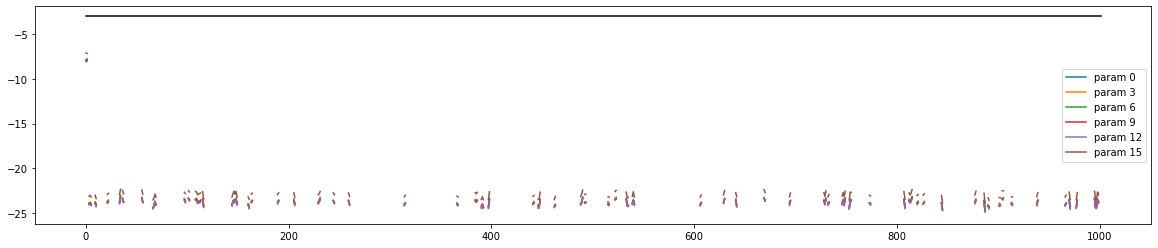

In [108]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

